# Spam Classification

Mini project.<br>
Performed as part of my Certificate program  at Ryerson Univerity
<br>
The prblem Statement: Create a prediction model, using supervised classifcation, that best predicts whether SMS messgages are spam.

In [123]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
%matplotlib inline

The dataset used for this mini-project is the SMS Spam Collection obtained from the UCI Machine Learning Repository.<br>It can be accessed here: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

## Import the dataset

In [102]:
df = pd.read_csv('SMSSpamCollection',sep='\t',header=None,names=['class','text'])

In [103]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [104]:
df.shape

(5572, 2)

## Explore the text data

While this step is not necessary for generating the prediction model, I am performing it to see if I can uncover any insights into spam or ham messages.

In [105]:
df_viz = df.groupby('class').count()
df_viz

,text
class,
ham,4825
spam,747


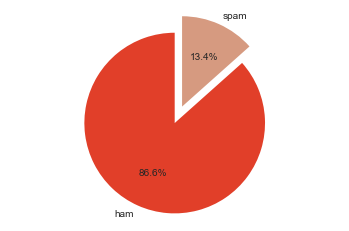

In [106]:
# Create a list of colors (from iWantHue)
myColors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B", "#EB8076", "#96624E"]

explode2 = (0.1, 0.1)

labels = df_viz.index.values
sizes = df_viz.text.values
explode = explode2  

         
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = myColors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We can see from the chart above that we have an unbalanced dataset.  This may impact our overall performance.<br> Ideally we have more of a balanced dataset, and if this were being put into production, we should strive to have more spam data included in the labeled dataset.

In [107]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Word Frequency

I will filter the dataset by spam or ham and create a new dataframe for each

In [108]:
df_spam = df[df['class'] =='spam']
df_ham = df[df['class'] == 'ham']
df_ham.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...


In [109]:
import re
from collections import Counter
import nltk
import nltk
from nltk.corpus import stopwords
import nltk.classify.util

In [110]:
df_spam['text2'] = df_spam.text.str.lower()
df_ham['text2'] = df_ham.text.str.lower()

In [111]:
df_spam['text2'] = df_spam.text2.str.replace('\W+',' ')
df_ham['text2'] = df_ham.text2.str.replace('\W+',' ')

In [112]:
df_spam['text2']= df_spam.text2.str.replace('!+',' ')
df_spam['text2'] = df_spam.text2.str.replace('\?+',' ')
df_spam['text2'] = df_spam.text2.str.replace('?',' ')
df_ham['text2']= df_ham.text2.str.replace('!+',' ')
df_ham['text2'] = df_ham.text2.str.replace('\?+',' ')
df_ham['text2'] = df_ham.text2.str.replace('?',' ')

In [118]:
stop = stopwords.words('english')
df_spam['norm'] = df_spam['text2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

all_words_spam = pd.Series([y for x in df_spam.norm.values.flatten() for y in x.split()]).value_counts()
top_20_spam = all_words_spam[0:20]

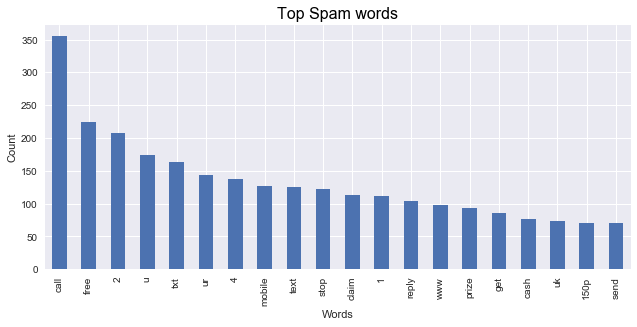

In [125]:
top_20_spam.plot(kind='bar')
plt.title("Top Spam words", loc='center', fontsize=16, fontweight=1, color='black')
plt.xlabel("Words")
plt.ylabel("Count")
fig = mpl.pyplot.gcf()
fig.set_size_inches(10.5, 4.5)

In [126]:
stop = stopwords.words('english')
df_ham['norm'] = df_ham['text2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
import nltk.classify.util
all_words_ham = pd.Series([y for x in df_ham.norm.values.flatten() for y in x.split()]).value_counts()
top_20_ham = all_words_ham[0:20]

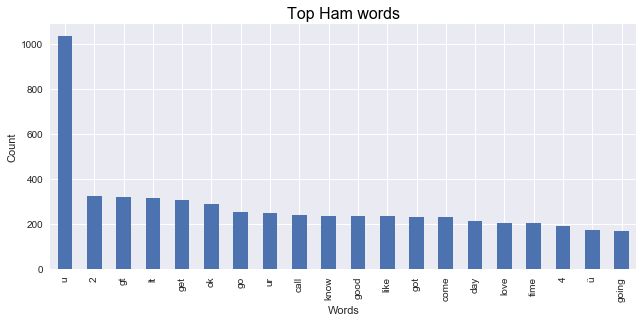

In [127]:
top_20_ham.plot(kind='bar')
plt.title("Top Ham words", loc='center', fontsize=16, fontweight=1, color='black')
plt.xlabel("Words")
plt.ylabel("Count")
fig = mpl.pyplot.gcf()
fig.set_size_inches(10.5, 4.5)

## Split into test data and training data

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.25)

## Preparing the data for the model

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer

In [34]:
count_vect = CountVectorizer()

In [35]:
X_train_counts = count_vect.fit_transform(X_train)

In [36]:
list(count_vect.vocabulary_.items())[0:3]

[('then', 6518), ('any', 978), ('other', 4763)]

In [37]:
len(count_vect.vocabulary_)

7412

In [38]:
lab_bin=LabelBinarizer()
y_train_bin=lab_bin.fit_transform(y_train)
y_test_bin=lab_bin.fit_transform(y_test)

## Training the model

In [55]:
from sklearn.naive_bayes import MultinomialNB
import collections
from sklearn.metrics import average_precision_score

In [128]:
clf = MultinomialNB().fit(X_train_counts, y_train_bin)

In [46]:
len(clf.coef_[0])

7412

In [59]:
keyWords = collections.Counter()

In [60]:
for word,imp in zip(count_vect.vocabulary_.keys(),clf.coef_[0]):
    keyWords[word]=imp

In [61]:
keyWords.most_common()[-10:]

[('strip', -9.91655184186533),
 ('1013', -9.91655184186533),
 ('bowls', -9.91655184186533),
 ('requirements', -9.91655184186533),
 ('930', -9.91655184186533),
 ('db', -9.91655184186533),
 ('unlike', -9.91655184186533),
 ('turkeys', -9.91655184186533),
 ('gloucesterroad', -9.91655184186533),
 ('tomorro', -9.91655184186533)]

In [62]:
keyWords.most_common()[0:10]

[('helens', -3.6685089673569005),
 ('wifes', -4.3330555330836305),
 ('didntgive', -4.496016842593043),
 ('jenxxx', -4.685443225010743),
 ('complaint', -4.810606367964749),
 ('costume', -4.841378026631503),
 ('mustprovide', -4.847647639645098),
 ('onum', -4.8666958346157925),
 ('devouring', -4.960724784264069),
 ('korean', -5.129060099083284)]

## Perform on test dataset

In [53]:
X_test_counts = count_vect.transform(X_test)

In [54]:
pred=clf.predict(X_test_counts)

In [56]:
average_precision_score(y_test_bin,pred)

0.9335475190158443

## Testing the classifier 

In [135]:
clf.predict(count_vect.transform(["click here to win this prize"]))

array([1])

In [136]:
clf.predict(count_vect.transform(["heya, how's it going. we still meerting at 3?"]))

array([0])

In [137]:
clf.predict(count_vect.transform(["I luv you"]))

array([0])

In [138]:
clf.predict(count_vect.transform(["buy now and save $100!"]))

array([1])